In [117]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, LSTM, Dropout

## 1st Dataset

In [172]:
df = pd.read_csv('data_train_3.csv', sep='\t', header=None, names=['id', 'label', 'tweet'])\
    .set_index('id')

In [173]:
def tokenize(values):
    tokenizer = Tokenizer(num_words=2500, lower=True, split=' ')
    tokenizer.fit_on_texts(values)
    return tokenizer

def preprocessing(tokenizer, values):
    X = tokenizer.texts_to_sequences(values)
    X = pad_sequences(X, maxlen=50)
    return X

In [174]:
tokenizer = tokenize(df.tweet.values)

In [175]:
X = preprocessing(tokenizer, df.tweet.values)

In [176]:
embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2500, embed_dim, input_length = X.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/Users/paulvilledieu/SCIA/Introduction-DeepLearning/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/Users/paulvilledieu/SCIA/Introduction-DeepLearning/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 128)           320000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 603       
Total params: 583,803
Trainable params: 583,803
Non-trainable params: 0
_________________________________________________________________
None


In [186]:
Y = pd.get_dummies(df['label']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state = 36)

#Here we train the Network.

history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size =batch_size, nb_epoch = 2)

Train on 40266 samples, validate on 10067 samples
Epoch 1/2
   96/40266 [..............................] - ETA: 1:16 - loss: 0.5913 - acc: 0.7604

/Users/paulvilledieu/SCIA/Introduction-DeepLearning/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


40266/40266 [==============================] - 67s 2ms/step - loss: 0.6307 - acc: 0.7212 - val_loss: 0.7848 - val_acc: 0.6507
Epoch 2/2
40266/40266 [==============================] - 69s 2ms/step - loss: 0.5961 - acc: 0.7405 - val_loss: 0.8066 - val_acc: 0.6421


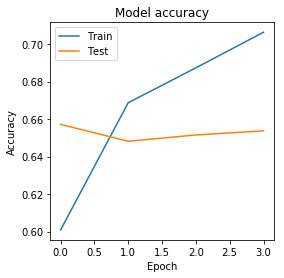

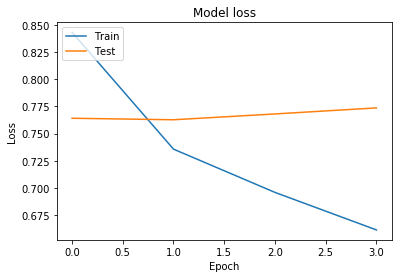

In [185]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [187]:
base_model = model

## 2nd Dataset

In [188]:
df = pd.read_csv('2018-Valence-oc-En-train.txt', sep='\t')\
    .rename(columns={"ID": "id", "Tweet": "tweet", "Affect Dimension": "dim", "Intensity Class": "label"})\
    .set_index('id')\
    .drop(columns=['dim'])

In [189]:
df.label = df.label.apply(lambda x: x.split(':')[0])

In [190]:
X = preprocessing(tokenizer, df.tweet.values)

In [201]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = model.layers[-2].output
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=7)

In [202]:
finetune_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9_input (InputLaye (None, 50)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 50, 128)           320000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_47 (Dense)             (None, 1024)              205824    
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_26 (Dropout)         (None, 1024)              0         
__________

In [203]:
finetune_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [204]:
Y = pd.get_dummies(df['label']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state = 36)

#Here we train the Network.

history = finetune_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size =batch_size, nb_epoch = 2)

/Users/paulvilledieu/SCIA/Introduction-DeepLearning/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 944 samples, validate on 237 samples
Epoch 1/2
944/944 [==============================] - 3s 3ms/step - loss: 1.7291 - acc: 0.3157 - val_loss: 1.5820 - val_acc: 0.3586
Epoch 2/2
944/944 [==============================] - 1s 1ms/step - loss: 1.6451 - acc: 0.3411 - val_loss: 1.5815 - val_acc: 0.3460


In [205]:
score, acc = finetune_model.evaluate(X_valid, Y_valid, batch_size=batch_size)
print(f'Score: {score}')
print(f'Val accuracy: {acc}')

237/237 [==============================] - 0s 463us/step
Score: 1.5814656024240743
Val accuracy: 0.3459915618101756


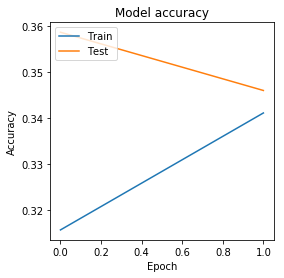

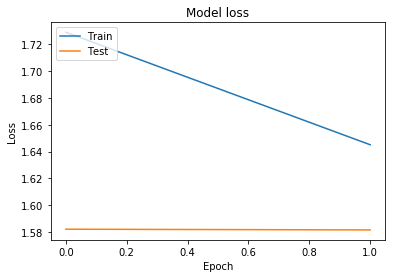

In [206]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(4,4))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [207]:
df_test = pd.read_csv('2018-Valence-oc-En-dev.txt', sep='\t')\
    .rename(columns={"ID": "id", "Tweet": "tweet", "Affect Dimension": "dim", "Intensity Class": "label"})\
    .set_index('id')\
    .drop(columns=['dim'])

In [208]:
df_test.label = df_test.label.apply(lambda x: x.split(':')[0])

In [209]:
X_test = preprocessing(tokenizer, df_test.tweet.values)

In [210]:
Y_test = pd.get_dummies(df_test['label']).values
Y_pred = finetune_model.predict(X_test)

In [217]:
score, acc = finetune_model.evaluate(X_test, Y_test, batch_size=batch_size)
print(f'Score: {score}')
print(f'Val accuracy: {acc}')

449/449 [==============================] - 0s 459us/step
Score: 1.6805733144947044
Val accuracy: 0.3429844097995546


In [220]:
Y_test

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [230]:
from scipy.stats import pearsonr

def pearson_metric(y_pred, y_test):
    y_pred = np.argmax(y_pred, axis=1) - 3
    y_test = np.argmax(y_test, axis=1) - 3
    return pearsonr(y_test, y_pred)[0]

In [231]:
pearson_metric(Y_pred, Y_test)

0.5168686329996931

In [240]:
from sklearn.metrics import cohen_kappa_score

def kappa_metric(y_pred, y_test):
    y_pred = np.argmax(y_pred, axis=1) - 3
    y_test = np.argmax(y_test, axis=1) - 3
    return cohen_kappa_score(y_pred, y_test)

In [241]:
kappa_metric(Y_pred, Y_test)

0.17686867682517593